<a href="https://colab.research.google.com/github/alpharmike/pytorch-hands-on/blob/main/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 38.91 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f624646eda0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [13]:
# Setup the model with pretrained weights and send it to the target device
# model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_0 = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model_0 # uncomment to output (it's very long)

In [14]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [15]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_0,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [16]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [17]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [18]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 9.452 seconds


### Make predictions on the entire test dataset with the model

In [80]:
def plot_predictions(samples: list):
  # Plot predictions
  plt.figure(figsize=(9, 9))
  nrows = 3
  ncols = 3
  for i, (sample, true_label, pred_label, pred_prob) in enumerate(samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze().permute((1, 2, 0)));

    pred_label_text = class_names[pred_label]

    true_label_text = class_names[true_label]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label_text} | Truth: {true_label_text}\nProb: {pred_prob:.3f}"

    if pred_label == true_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);

In [184]:
# TODO
import random

def predict_on_data(data_loader):
  correctly_classified_samples = []
  misclassified_samples = []
  true_labels = []
  pred_labels = []

  model_0.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)
      y_logits = model_0(X)
      y_pred_probs = torch.softmax(y_logits, dim=1)
      y_pred_labels = torch.argmax(y_pred_probs, dim=1)

      true_labels.append(y)
      pred_labels.append(y_pred_labels)

      correctly_classified_sample_indices = y == y_pred_labels

      for index, index_val in enumerate(correctly_classified_sample_indices):
        record = (X[index].cpu(), y[index].cpu(), y_pred_labels[index].cpu(), y_pred_probs[index].max().cpu())
        if index_val:
          correctly_classified_samples.append(record)
        else:
          misclassified_samples.append(record)

  return correctly_classified_samples, misclassified_samples, torch.concat(true_labels), torch.concat(pred_labels)

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [53]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [54]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


In [185]:
correctly_classified_samples, misclassified_samples, true_labels, pred_labels = predict_on_data(test_dataloader)

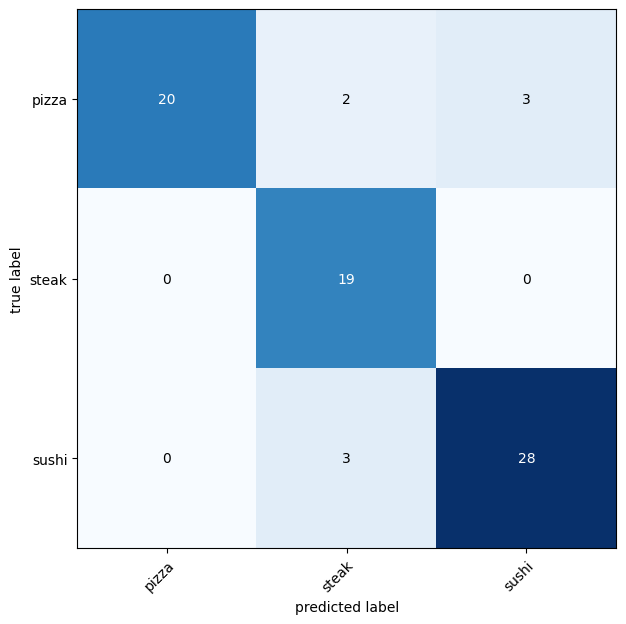

In [186]:
# TODO
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass').to(device)
confmat_tensor = confmat(preds=pred_labels,
                         target=true_labels)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

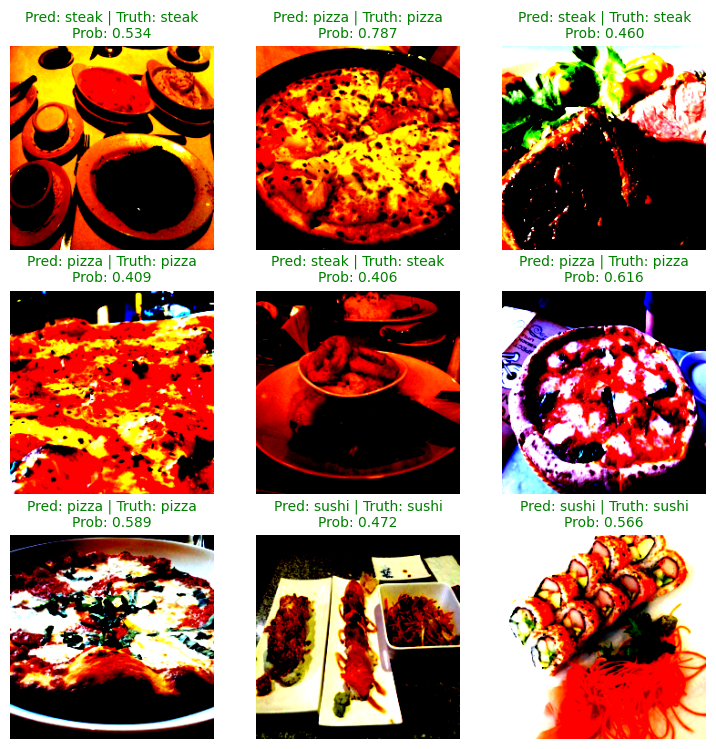

In [187]:
# TODO
correctly_classified_samples_subset = random.sample(correctly_classified_samples, k=9)
plot_predictions(correctly_classified_samples_subset)

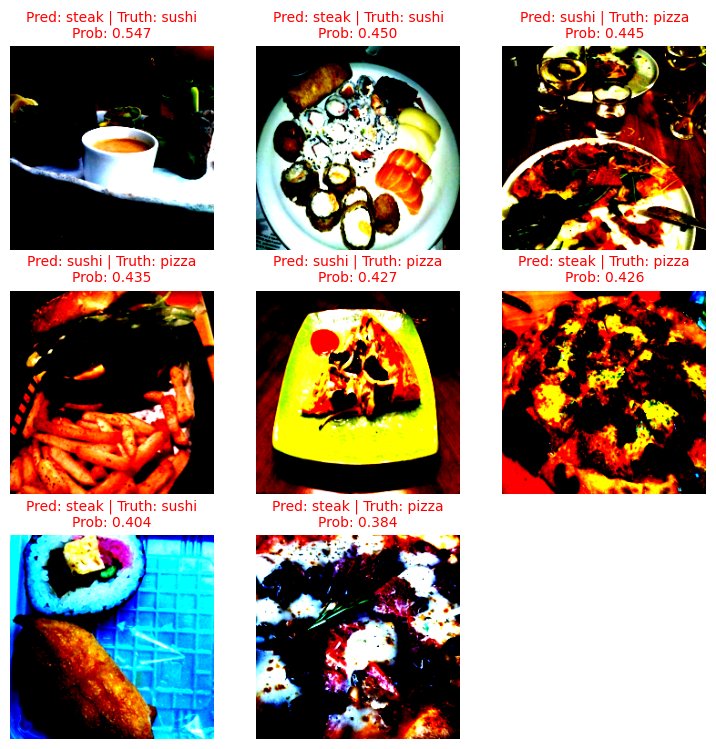

In [188]:
misclassified_samples_subset = random.sample(misclassified_samples, k=8)
misclassified_samples_subset.sort(key = lambda x: x[3], reverse=True) # x[3] is the prediction probability
plot_predictions(misclassified_samples_subset)

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [96]:
from going_modular.going_modular import predictions

In [90]:
def download_image(image_url: str, image_path: Path):
  if image_path.is_file():
    print("Custom image already exists, skipping the download...")
  else:
    image = requests.get(image_url)
    with open(image_path, "wb") as f:
      f.write(image.content)

Custom image already exists, skipping the download...


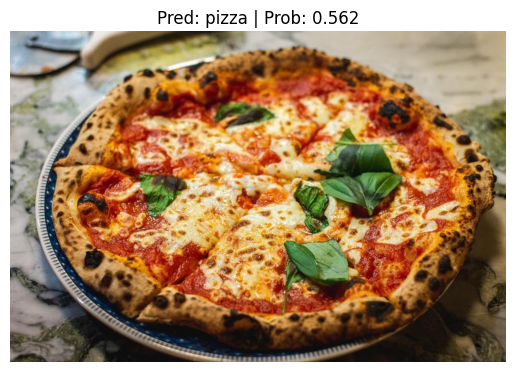

In [97]:
# TODO: Get an image of pizza/steak/sushi
pizza_image_url = "https://img.zeit.de/zeit-magazin/wochenmarkt/2023-08/pizza-margherita-giovanni-stincone-rezept/super__450x300__mobile__scale_2"
pizza_image_path = data_path / "custom_pizza.jpg"
download_image(pizza_image_url, pizza_image_path)
predictions.pred_and_plot_image(
    model=model_0,
    class_names=class_names,
    image_path=pizza_image_path,
    image_size=(224, 224),
    transform=simple_transform
)

Custom image already exists, skipping the download...


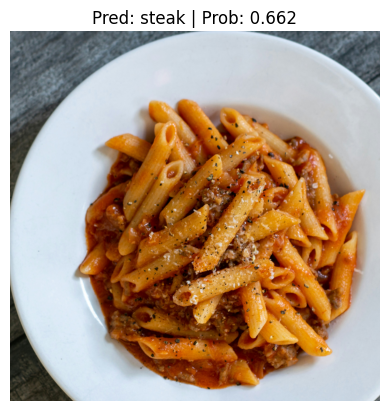

In [98]:
# TODO: Get an image of not pizza/steak/sushi
pasta_image_url = "https://unsplash.com/photos/flFd8L7_B3g/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8NHx8cGFzdGF8ZW58MHx8fHwxNzEyMjg0NDkwfDA&force=true"
pasta_image_path = data_path / "custom_pasta.jpg"
download_image(pasta_image_url, pasta_image_path)
predictions.pred_and_plot_image(
    model=model_0,
    class_names=class_names,
    image_path=pasta_image_path,
    image_size=(224, 224),
    transform=simple_transform
)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [129]:
# TODO: Recreate a new model
weights_1 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights_1).to(device)

In [130]:
for param in model_1.features.parameters():
    param.requires_grad = False

In [131]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [132]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [133]:
# TODO: Train the model for 10 epochs
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6022 | train_acc: 0.7656 | test_loss: 0.5565 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5411 | train_acc: 0.9258 | test_loss: 0.5279 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5493 | train_acc: 0.8086 | test_loss: 0.5291 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5725 | train_acc: 0.7969 | test_loss: 0.4947 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.5219 | train_acc: 0.7969 | test_loss: 0.4207 | test_acc: 0.8655
Epoch: 11 | train_loss: 0.4408 | train_acc: 0.9258 | test_loss: 0.4226 | test_acc: 0.9072
Epoch: 12 | train_l

,train_loss,train_acc,test_loss,test_acc
0,1.089491,0.441406,0.920231,0.508523
1,0.868203,0.773438,0.802167,0.743371
2,0.777095,0.781250,0.739891,0.773674
3,0.724853,0.742188,0.647178,0.886364
4,0.644501,0.781250,0.624355,0.896780


,train_loss,train_acc,test_loss,test_acc
0,1.089491,0.441406,0.920231,0.508523
1,0.868203,0.773438,0.802167,0.743371
2,0.777095,0.781250,0.739891,0.773674
3,0.724853,0.742188,0.647178,0.886364
4,0.644501,0.781250,0.624355,0.896780
5,0.602242,0.765625,0.556492,0.886364
6,0.541090,0.925781,0.527941,0.917614
7,0.549274,0.808594,0.529056,0.917614
8,0.572465,0.796875,0.494681,0.907197
9,0.521895,0.796875,0.420683,0.865530


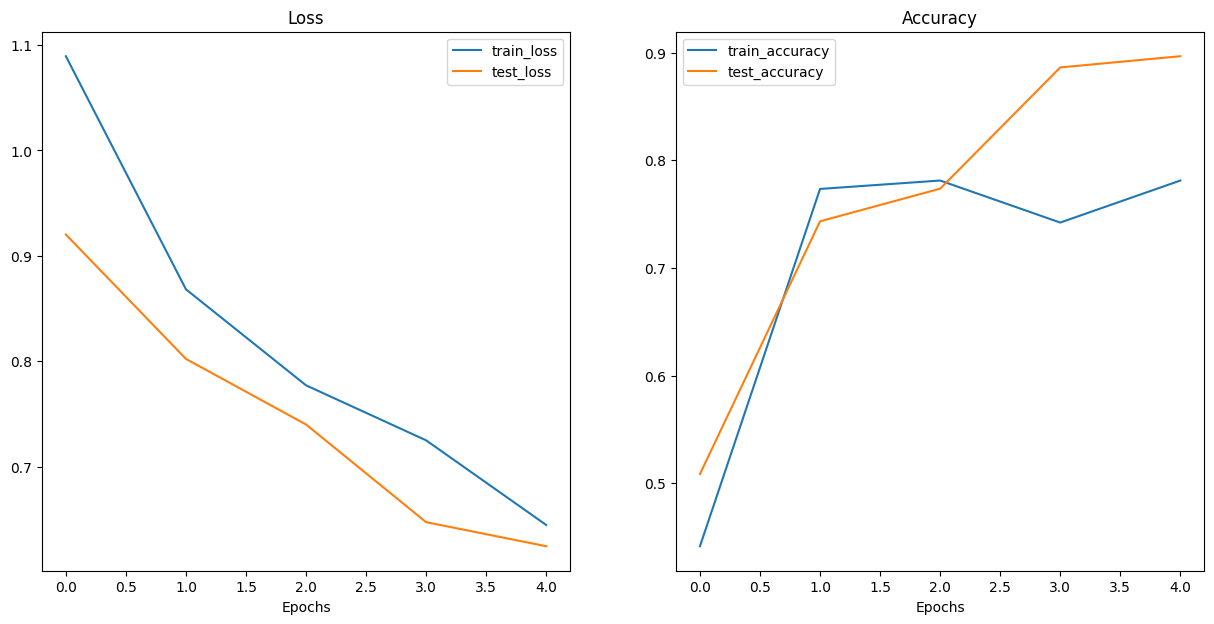

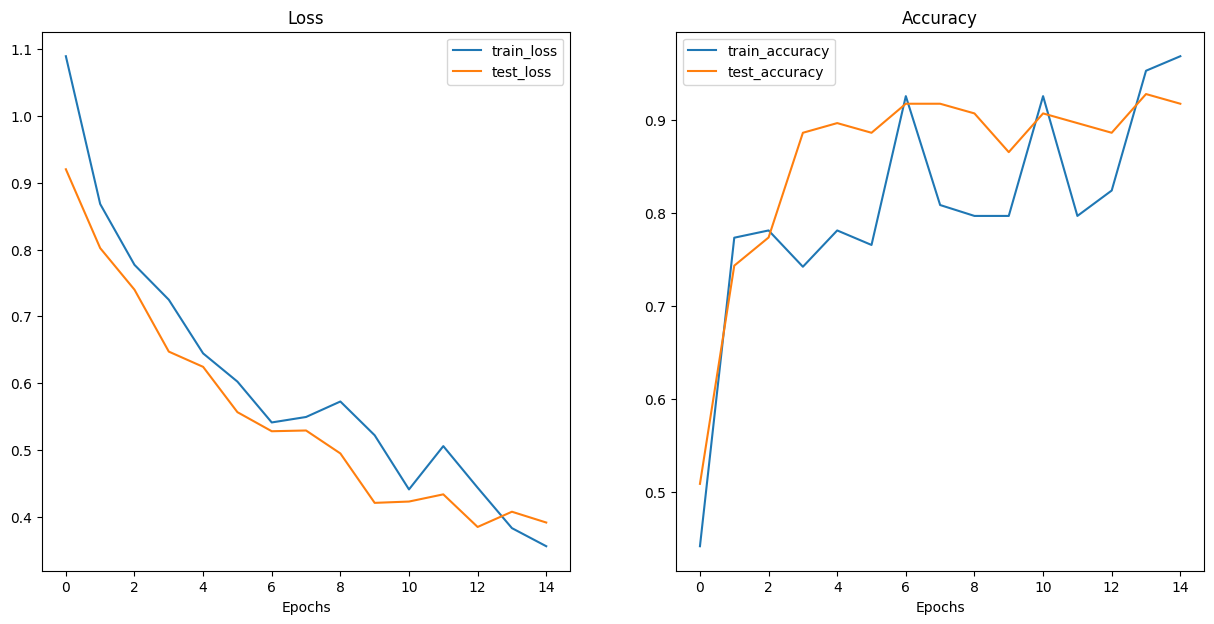

In [138]:
import pandas as pd
from going_modular.going_modular import utils

model_0_results_df = pd.DataFrame(model_0_results)
model_1_results_df = pd.DataFrame(model_1_results)

display(model_0_results_df)
display(model_1_results_df)

utils.plot_loss_curves(model_0_results)
utils.plot_loss_curves(model_1_results)

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [139]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [140]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [141]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f614b79dba0>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [153]:
weights_2 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights_2).to(device)

In [154]:
for param in model_2.features.parameters():
    param.requires_grad = False

In [155]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

### Train a model with 20% of the data

In [156]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [157]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

model_2_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9747 | train_acc: 0.5667 | test_loss: 0.6472 | test_acc: 0.8949
Epoch: 2 | train_loss: 0.7067 | train_acc: 0.8167 | test_loss: 0.5291 | test_acc: 0.9006
Epoch: 3 | train_loss: 0.5866 | train_acc: 0.8271 | test_loss: 0.4519 | test_acc: 0.8881
Epoch: 4 | train_loss: 0.4555 | train_acc: 0.8917 | test_loss: 0.4089 | test_acc: 0.8881
Epoch: 5 | train_loss: 0.4520 | train_acc: 0.8896 | test_loss: 0.3788 | test_acc: 0.9068
Epoch: 6 | train_loss: 0.4271 | train_acc: 0.8396 | test_loss: 0.3534 | test_acc: 0.9006
Epoch: 7 | train_loss: 0.4157 | train_acc: 0.8396 | test_loss: 0.3159 | test_acc: 0.9193
Epoch: 8 | train_loss: 0.3935 | train_acc: 0.8500 | test_loss: 0.3192 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3163 | train_acc: 0.8938 | test_loss: 0.3025 | test_acc: 0.9040
Epoch: 10 | train_loss: 0.3488 | train_acc: 0.9042 | test_loss: 0.2699 | test_acc: 0.9318
[INFO] Total training time: 33.337 seconds


,train_loss,train_acc,test_loss,test_acc
0,0.974651,0.566667,0.647208,0.894886
1,0.706723,0.816667,0.529121,0.900568
2,0.586574,0.827083,0.451879,0.888068
3,0.455495,0.891667,0.408941,0.888068
4,0.452045,0.889583,0.378806,0.906818
5,0.427142,0.839583,0.353374,0.900568
6,0.415699,0.839583,0.315864,0.919318
7,0.393537,0.850000,0.319240,0.897727
8,0.316266,0.893750,0.302491,0.903977
9,0.348796,0.904167,0.269872,0.931818


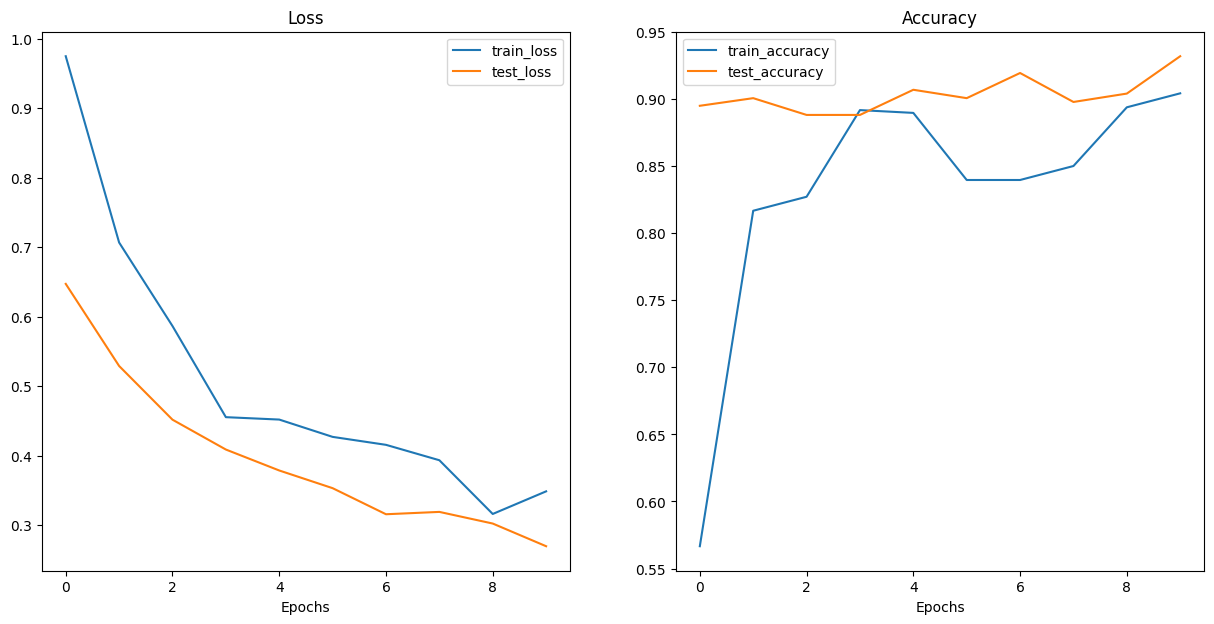

In [159]:
import pandas as pd
from going_modular.going_modular import utils

model_2_results_df = pd.DataFrame(model_2_results)

display(model_2_results_df)

utils.plot_loss_curves(model_2_results)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [175]:
weights_3 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_3 = torchvision.models.efficientnet_b2(weights=weights_3).to(device)

In [176]:
for param in model_3.features.parameters():
    param.requires_grad = False

In [177]:
summary(model=model_3,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [178]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape,
                    bias=True)).to(device)

In [179]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [180]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

model_3_results = engine.train(model=model_3,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9985 | train_acc: 0.5479 | test_loss: 0.7716 | test_acc: 0.9006
Epoch: 2 | train_loss: 0.7154 | train_acc: 0.8375 | test_loss: 0.6248 | test_acc: 0.8699
Epoch: 3 | train_loss: 0.5767 | train_acc: 0.8792 | test_loss: 0.5399 | test_acc: 0.8909
Epoch: 4 | train_loss: 0.4430 | train_acc: 0.8938 | test_loss: 0.4864 | test_acc: 0.8943
Epoch: 5 | train_loss: 0.4481 | train_acc: 0.8646 | test_loss: 0.4412 | test_acc: 0.8852
Epoch: 6 | train_loss: 0.4163 | train_acc: 0.8667 | test_loss: 0.4146 | test_acc: 0.9034
Epoch: 7 | train_loss: 0.4183 | train_acc: 0.8521 | test_loss: 0.3808 | test_acc: 0.9034
Epoch: 8 | train_loss: 0.3821 | train_acc: 0.8604 | test_loss: 0.4044 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3827 | train_acc: 0.8854 | test_loss: 0.3720 | test_acc: 0.8943
Epoch: 10 | train_loss: 0.3530 | train_acc: 0.8625 | test_loss: 0.3403 | test_acc: 0.9159
[INFO] Total training time: 33.975 seconds


,train_loss,train_acc,test_loss,test_acc
0,0.998467,0.547917,0.771639,0.900568
1,0.715384,0.837500,0.624825,0.869886
2,0.576737,0.879167,0.539941,0.890909
3,0.443042,0.893750,0.486356,0.894318
4,0.448096,0.864583,0.441156,0.885227
5,0.416279,0.866667,0.414555,0.903409
6,0.418341,0.852083,0.380800,0.903409
7,0.382118,0.860417,0.404392,0.897727
8,0.382689,0.885417,0.371965,0.894318
9,0.352996,0.862500,0.340259,0.915909


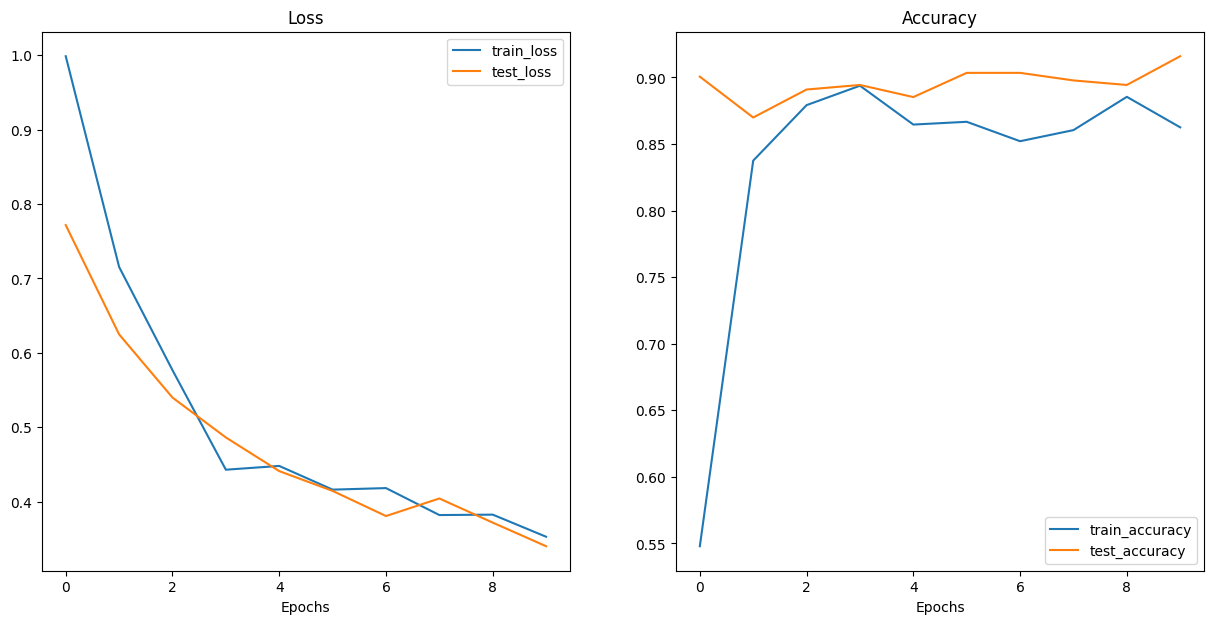

In [181]:
import pandas as pd
from going_modular.going_modular import utils

model_3_results_df = pd.DataFrame(model_3_results)

display(model_3_results_df)

utils.plot_loss_curves(model_3_results)

In [189]:
correctly_classified_samples, misclassified_samples, true_labels, pred_labels = predict_on_data(test_dataloader_20_percent)

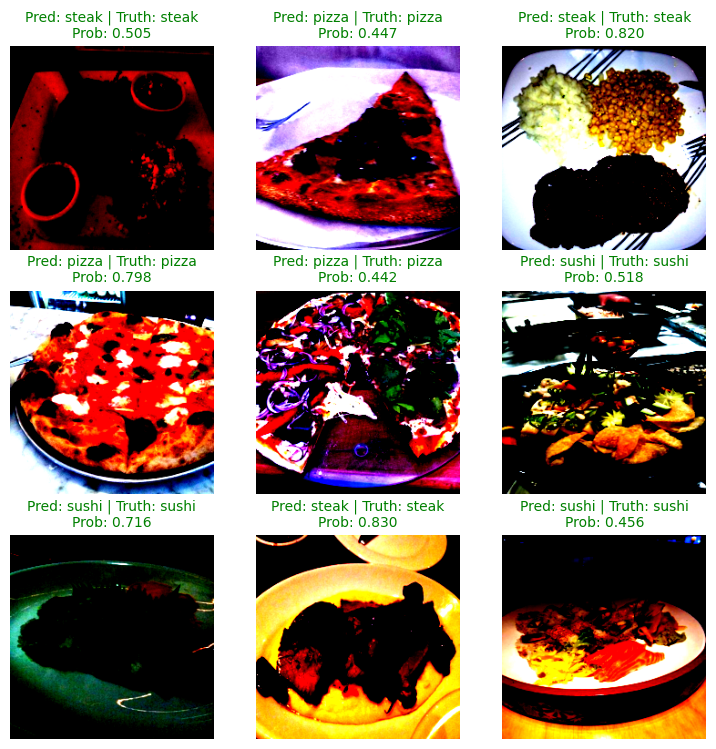

In [190]:
# TODO
correctly_classified_samples_subset = random.sample(correctly_classified_samples, k=9)
plot_predictions(correctly_classified_samples_subset)

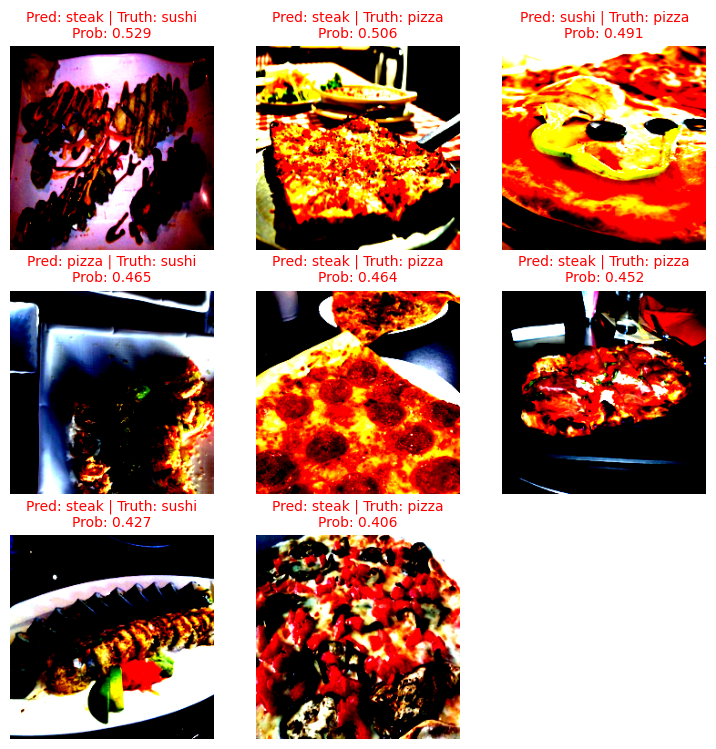

In [191]:
misclassified_samples_subset = random.sample(misclassified_samples, k=8)
misclassified_samples_subset.sort(key = lambda x: x[3], reverse=True) # x[3] is the prediction probability
plot_predictions(misclassified_samples_subset)